# RNNs Sequence to Sequence

Nas RNN $n \times m$ que vimos, a "interpretação" ocorre concomitantemente à "leitura". Muitas vezes, contudo, é melhor esperar primeiro por uma interpretação do todo para, só então, iniciar o processo de decodificação. 

Arquiteturas que usam esta estratégias são as __Seq2seq__. Elas consistem normalmente de duas RNNs, uma codificadora e uma decodificadora, que operam como ilustrado a seguir:

_sequência-entrada_ -> **[codificador]** -> _representação_ -> **[decodificador]** -> _sequência-saída_

Assim, a ideia geral é usar a representação interna de uma rede codificadora para capturar o significado e contexto da entrada. Esta informação é então fornecida para a decodificadora que pode, a partir de um símbolo de partida e da representação da codificadora, ir prevendo a próxima saída decodificada até o fim da sequência.  

Vamos estudar esta rede com uma aplicação em um problema muito comum em países de língua inglesa: soletrar uma palavra a partir de sua pronúncia.

### Soletrando a partir de pronúncias

No problema que vamos abordar, queremos traduzir a pronuncia de uma palavra, dada como uma lista de fonemas, para a grafia da palavra. Este problema é mais simples que _fala para texto_ ou _tradução_ (no sentido de não precisarmos de quantidades colossais de dados para ver algo acontecer [:)]); contudo, uma dificuldade aqui é a avaliação na escrita de palavras nunca vistas antes. Isto é díficil porque (1) há muitas pronúncias com várias transcrições razoáveis além de (2) palavras homônicas com transcrições distintas (_read_, no passado e presente, por exemplo). 

Um caso clássico do inglês é o tough, though, thought, through, thorough, throughout (qual é qual?)

### Manipulando os dados...

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Input, LSTM, Dense

E:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Inicialmente temos que ler o dicionário de fonemas da CMU, _The CMU pronouncing dictionary_. Neste exemplo, disponibilizamos uma versão dele como CSV, já restritoa apenas a palavras, evitando símbolos especiais.

In [3]:
pdic = pd.read_csv('data/cmudict-compact.csv', comment=';', 
                   header = -1, names = ['word', 'pronunciation'],
                   keep_default_na = False,encoding='latin1')

Em uma pequena amostra do dicionário, podemos ver as pronúncias codificadas com os símbolos da ARPAbet.

In [18]:
#pdic[40150:40155]
len(pdic)

50000

Embora não estritamente necessária para esta aula, temos abaixo um dicionário que indica para cada símbolo ARPAbet, seu correspondente IPA e uma palavra de exemplo que ilustra o som do fonema. Por exemplo, o som ʒ (ARPAbet ZH) corresponde ao som de /s/ em _pleasure_.

In [5]:
IPA_SYMBOLS = {'AXR':('ɚ','letter'), 'IY':('i','beat'), 'W':('w','wise'), 
               'DH':('ð','thy'), 'EL':('l̩','bottle'), 'WH':('ʍ','why'), 
               'Y':('j','yacht'), 'HH':('h','high'), 'CH':('tʃ','China'), 
               'JH':('dʒ','jive'), 'DX':('ɾ','butter'), 'ZH':('ʒ','pleasure'), 
               'EM':('m̩','rhythm'), 'D':('d','die'), 'NG':('ŋ','sing'), 
               'NX':('ɾ̃','winner'), 'TH':('θ','thigh'), 'H':('h','high'), 
               'AA':('ɑ','bot'), 'IX':('ɨ','rabbit'), 'B':('b','buy'), 
               'AE':('æ','bat'), 'EH':('ɛ','bet'), 'G':('ɡ','guy'), 
               'F':('f','fight'), 'AH':('ʌ','butt'), 'K':('k','kite'), 
               'M':('m','my'), 'L':('l','lie'), 'AO':('ɔ','bought'), 
               'N':('n','nigh'), 'Q':('ʔ','uh-oh'), 'IH':('ɪ','bit'), 
               'S':('s','sigh'), 'R':('ɹ','rye'), 'EY':('eɪ','bait'), 
               'T':('t','tie'), 'AW':('aʊ','bout'), 'V':('v','vie'), 
               'AY':('aɪ','bite'), 'AX':('ə','about'), 'Z':('z','zoo'), 
               'ER':('ɝ','bird'), 'UX':('ʉ','dude'), 'P':('p','pie'), 
               'UW':('u','boot'), 'SH':('ʃ','shy'), 'UH':('ʊ','book'), 
               'OY':('ɔɪ','boy'), 'OW':('oʊ','boat'), 'EN':('n̩','button')}

def get_ipa_symbol(s):
    lc = ''
    if s[-1].isdigit():
        lc = s[-1]
        s = s[:-1]
    return IPA_SYMBOLS[s][0] + lc if s in IPA_SYMBOLS else ''

Assim, por exemplo, a palavra _facial_ tem pronúnica _f-eɪ-ʃ-ʌ-l_ (F-EY1-SH-AH0-L, em ARPAbet, ou os sons de /f/ em _fight_, /ai/ em _bait_, /sh/ em _shy_, /u/ em _butt_ e /l/ em _lie_).

Para manter o problema em um tamanho razoável, vamos usar apenas uma fração do dicionário de fonemas. Também vamos filtrar as palavras muito curtas, muito longas ou com símbolos especiais.

In [6]:
num_samples = 50000  # Number of samples to train on.
pdic = pdic.sample(n = num_samples)

def filter_input(inp):    
    return ((len(inp) < 5 or      # filter long words 
             len(inp) > 15) or
            # filter words with not alphabetical chars
            any((not s.isalpha() for s in inp)))

Em nosso problema, a entrada serão as sequências de fonemas e a saída, as palavras. O script abaixo extrai todas as entradas (listas de fonemas) e alvos (palavras), bem como os conjuntos de símbolos observados nas entradas e alvos (note que os alvos são sempre precedidos de um símbolo que indica início de sequência ['\t'] e terminados em um que indica fim de sequência ['\n']):

In [7]:
# Vectorize the data.
input_texts = []
target_texts = []
input_symbols = set()
target_symbols = set()
for idx, cols in pdic.iterrows():
    target = cols['word']
    if filter_input(target):
        continue
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target + '\n' # sequence of letters
    target_texts.append(target_text) 
    input_text = cols['pronunciation'].split() # sequence of phonemes
    input_texts.append(input_text)
    for symbol in input_text:
        if symbol not in input_symbols:
            input_symbols.add(symbol)
    for symbol in target_text:
        if symbol not in target_symbols:
            target_symbols.add(symbol)


Abaixo, obtemos algumas estatísticas sobre nossos dados:

In [8]:
input_symbols = sorted(list(input_symbols))
target_symbols = sorted(list(target_symbols))
num_encoder_tokens = len(input_symbols)
num_decoder_tokens = len(target_symbols)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('Number of unique input tokens:', num_encoder_tokens)
print('-', ' '.join(input_symbols))
print('Number of unique output tokens:', num_decoder_tokens)
print('-', repr(' '.join(target_symbols)))

Number of samples: 40283
Max sequence length for inputs: 16
Max sequence length for outputs: 17
Number of unique input tokens: 69
- AA0 AA1 AA2 AE0 AE1 AE2 AH0 AH1 AH2 AO0 AO1 AO2 AW0 AW1 AW2 AY0 AY1 AY2 B CH D DH EH0 EH1 EH2 ER0 ER1 ER2 EY0 EY1 EY2 F G HH IH0 IH1 IH2 IY0 IY1 IY2 JH K L M N NG OW0 OW1 OW2 OY0 OY1 OY2 P R S SH T TH UH0 UH1 UH2 UW0 UW1 UW2 V W Y Z ZH
Number of unique output tokens: 28
- '\t \n A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'


Abaixo, vamos criar os mapas que vão fornecer os mapeamentos de cada símbolo para o seu índice correspondente. Com isso, iniciamos os vetores de embeddings que serão usados para representar cada um dos símbolos:

In [9]:
input_token_index = dict(
    [(s, i) for i, s in enumerate(input_symbols)])
target_token_index = dict(
    [(s, i) for i, s in enumerate(target_symbols)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

A codificação que vamos usar aqui é _one-hot-vector_:

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, sym in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[sym]] = 1.
    for t, sym in enumerate(target_text):
        # decoder_target_data is ahead of decoder_target_data by one timestep
        decoder_input_data[i, t, target_token_index[sym]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[sym]] = 1.

Abaixo, podemos visualizar uma das matrizes de representação esparsas geradas. As colunas correspondem aos símbolos e as linhas ao tempo. Cada 1 foi representado como um asterisco em um mar de pontos ;). 

In [11]:
def print_mat_as_map(m):
    print('   tnABCDEFGHIJKLMNOPQRSTUVWXYZ')
    for i in range(m.shape[0]):
        print('%2d ' % i, end='')
        for j in range(m.shape[1]):
            print('%s' % '.' if m[i,j]==0 else '*', end='')
        print('\n', end='')
        
print('%s'%repr(target_texts[0]))
print_mat_as_map(decoder_target_data[0, :, :])

'\tALIZAC\n'
   tnABCDEFGHIJKLMNOPQRSTUVWXYZ
 0 ..*.........................
 1 .............*..............
 2 ..........*.................
 3 ...........................*
 4 ..*.........................
 5 ....*.......................
 6 .*..........................
 7 ............................
 8 ............................
 9 ............................
10 ............................
11 ............................
12 ............................
13 ............................
14 ............................
15 ............................
16 ............................


Em uma aplicação com palavras (ex: tradução de idiomas), esta codificação seria muito ineficiente em espaço e carga semântica. Nestes casos, vamos optar por uma representação densa, ou seja, um _embedding_ de palavras. Estes serão obtidos de rede neural que modele linguagem. Há muitas disponíveis, incluindo várias arquiteturas baseadas em RNN/LSTM. As mais comumente usadas hoje, contudo, são redes rasas que codificam as palavras considerando suas co-ocorrências em grandes corpora de texto (ex: word2vec e Glove).

### Implementando em tensorflow, usando Keras

Agora que os dados foram representados, podemos criar nossa arquitetura seq2seq:

<img src="images/rnn_s2s0.png" alt="Exemplo de RNN" style="width: 600px;"/>

A primeira metade da RNN age como um codificador, processando a sequência de entrada e retornando seu próprio estado interno. As saídas são descartadas e nem aparecem no desenho. O estado interno serve como contexto e condiciona a estimativa do decodificador.

<div style="background-color:rgba(229, 255, 204, 0.5); text-align:left; vertical-align: middle; padding:10px 10px;">

Note que como vamos usar unidades LSTMs, o estado interno é constituído pela codificação que a LSTM gerou da entrada ($h_t$) e pela sua memória ($c_t$), conforme ilustrado abaixo:

<img src="images/lstmcell.png" alt="célula LSTM" style="width: 200px;"/>

</div>

A outra RNN é o decodificador. Ela é treinada para prever o próximo elemento na sequência alvo, dado seus predecessores. Ou seja, para ela a entrada é a sequência alvo e o alvo é a sequência alvo, um passo à frente (esse processo é chamado de 'teacher forcing'). O estado inicial do decodificador é o estado final do codificador. Ou seja, o decodificador aprende a gerar alvos[t+1..] de alvos[t...] condicionado à sequência de entrada.

In [12]:
latent_dim = 256  # Latent dimensionality of the encoding space.

In [13]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [14]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [15]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 69)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 28)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 333824      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  291840      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [16]:
batch_size = 64  # Batch size for training.
epochs = 20 # 10  # Number of epochs to train for.

In [17]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('/tmp/ks2s.h5')

Train on 32226 samples, validate on 8057 samples
Epoch 1/20
32226/32226 [==============================] - 36s 1ms/step - loss: 1.2205 - val_loss: 1.0282
Epoch 2/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.9215 - val_loss: 0.8299
Epoch 3/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.7440 - val_loss: 0.6546
Epoch 4/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.5852 - val_loss: 0.5521
Epoch 5/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.4729 - val_loss: 0.4469
Epoch 6/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.4028 - val_loss: 0.4038
Epoch 7/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.3525 - val_loss: 0.3549
Epoch 8/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.3142 - val_loss: 0.3369
Epoch 9/20
32226/32226 [==============================] - 33s 1ms/step - loss: 0.2832 - val_loss: 0.3124
Epoch 

E:\Anaconda\lib\site-packages\keras\engine\network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Para fazer a inferência, iremos usar a seguinte estratégia:

1. Obtenha o estado do codificador para a sequência de entrada.
2. Inicie com uma sequência alvo de tamanho 1 (apenas o símbolo de início de sequência).
3. Dê o estado do codificador e a sequência criada até agora para o decodificador produzir uma distribuição de probabilidade para o próximo símbolo.
4. Amostre o próximo símbolo usando a distribuição (no exemplo a sequir, é apenas usado argmax).
5. Concatene o símbolo amostrado para a sequêcia alvo
6. Repita desde 1 até encontrar o símbolo de fim de sequência ou alcançar o tamanho máximo de representação da saída.

Note que esta estratégia poderia ter sido usada para treinar a rede também.

In [19]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

Vamos testar o nosso modelo de inferência.

In [20]:
# code a set of phonemes into an input for the RNN
def encoder_test(phones):
    encoder_test_data = np.zeros((1, max_encoder_seq_length, 
                                  num_encoder_tokens), dtype='float32')
    for t, sym in enumerate(phones.split(' ')):
        encoder_test_data[0, t, input_token_index[sym]] = 1.
    return encoder_test_data

In [21]:
# show decoder softmax distribuition 
def plot_decoded_dist(v):
    axis = np.arange(num_decoder_tokens)
    fig, ax = plt.subplots()
    ax.bar(axis, v, align = 'center')
    ax.set_xticks(axis)
    ax.set_xticklabels([c for c in '<>ABCDEFGHIJKLMNOPQRSTUVWXYZ'])
    plt.xlim([0, num_decoder_tokens])
    plt.show()

In [24]:
encoder_test_data = encoder_test('UW1 L ER0')
encoder_test_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [23]:
# Encode the input as state vectors.
states_value = encoder_model.predict(encoder_test_data)
print(states_value[0].shape, states_value[1].shape)

(1, 256) (1, 256)


In [26]:
# Generate empty target sequence of length 1.
target_seq = np.zeros((1, 1, num_decoder_tokens))
# Populate the first character of target sequence with the start character.
target_seq[0, 0, target_token_index['\t']] = 1.
decoder_input = [target_seq] + states_value
print(decoder_input[0].shape, decoder_input[1].shape, decoder_input[2].shape)

(1, 1, 28) (1, 256) (1, 256)


In [27]:
output_tokens, h, c = decoder_model.predict(decoder_input)

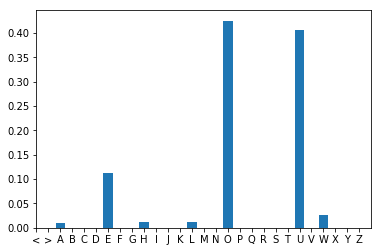

In [28]:
plot_decoded_dist(output_tokens[0,0,:])

In [29]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    start = 0 if decoded_sentence[0] != ' ' else 1
    return decoded_sentence[start:]

In [31]:
print('%15s %15s = %s' % ('Guess', 'Correct', 'Phonemes'))
for seq_index in range(50):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    inputs = ' '.join(input_texts[seq_index])
    correct = pdic[pdic['pronunciation']==inputs]['word'].iloc[0]
    ok = '+' if decoded_sentence[:-1] == correct else ' '
    ipa_inputs = ' '.join([get_ipa_symbol(c) for c in inputs.split(' ')])
    print('%15s %15s %s %s'%(decoded_sentence[:-1], correct, ok, ipa_inputs))  
    #print('%15s %15s %s %s'%(decoded_sentence[:-1], correct, ok, inputs))  

          Guess         Correct = Phonemes
         ALIZAK          ALIZAC   æ1 l ɪ0 z æ0 k
      DETHRONED       DETHRONED + d ɪ0 θ ɹ oʊ1 n d
        DUMMING         DUMBING   d ʌ1 m ɪ0 ŋ
    COMMONSENSE     COMMONSENSE + k ɑ2 m ʌ0 n s ɛ1 n s
         BROOKS          BROOKS + b ɹ ʊ1 k s
      STRICKLER       STRICKLER + s t ɹ ɪ1 k l ɝ0
        VASICEK         VASICEK + v ɑ1 s ɪ0 tʃ ɛ0 k
        INSAFOR         INSOFAR   ɪ1 n s ʌ0 f ɑ0 ɹ
          GOONS           GOONS + ɡ u1 n z
        PIGGOTT         PIGGOTT + p ɪ1 ɡ ʌ0 t
       DELADGER        DELAWDER   d ɛ1 l ɔ0 d ɝ0
          GORON          GARONE   ɡ ɝ0 oʊ1 n
          ALTOS           ALTOS + æ1 l t oʊ0 z
       PRETEENS        PRETEENS + p ɹ i2 t i1 n z
       PLATONIC        PLATONIC + p l ʌ0 t ɑ1 n ɪ0 k
      INCREASES       INCREASES + ɪ2 n k ɹ i1 s ɪ0 z
     GARCZYNSKI      GORCZYNSKI   ɡ ɝ0 tʃ ɪ1 n s k i0
      DOWNSIZED       DOWNSIZES   d aʊ1 n s aɪ2 z ɪ0 z
      ORIGINATE       ORIGINATE + ɝ0 ɪ1 dʒ ʌ0 n eɪ2 t
    LEPRE

### Mecanismos de Atenção

Em nosso modelo, quando o decodificador processa suas entradas, toda a informação de contexto se concentra nos estados recebidos do codificador. Deste modo, a entrada do decodificador é um gargalo e ele não tem como relacionar diretamente aspectos sendo decodificados com os elementos fonte diretamente associados a estes aspectos. 

Este é um problema particularmente importante com sequências muito longas. Nestes casos, à medida que o decodificador processa a informação, ele tende a ficar menos preso à fonte e mais impressionado com o material que esta produzindo. 

Por exemplo, imagine que a frase a ser traduzida seja `You can't make an omelet without breaking a few legs`. Ao alcançar a tradução de `legs`, a rede pode achar que é mais provável a palavra `ovos` (`eggs`) porque ela é mais razoável no contexto da sentença sendo gerada (`Você não pode fazer um omelete sem quebrar alguns...`), _a despeito dela não ser a tradução correta_. Este problema se manifesta de várias formas. Em modelos de tradução, por exemplo, o decodificador 'esquece' a concordância de gênero, tempo, pessoa, etc.

Para resolver este problema, Bahdanau et al., 2015 (https://arxiv.org/abs/1409.0473) e Luong et al., 2015 (https://arxiv.org/abs/1508.04025) introduziram a ideia de _mecanismos de atenção_. 

A ideia central é o estabelecimento de uma ligação direta entre as estimativas do codificador e do decodificador, de forma que o codificador preste atenção em informações relevantes do decodificador enquanto ele traduz/decodifica. Como resultado, este mecanismo ajuda muito na tradução de sentenças longas e se tornou o padrão de fato em tradução, com aplicação também em diversos outros problemas (fala, sumarização, _captioning_, etc). 

Entre os vários mecanismos de atenção na literatura, vamos descrever o proposto por Luong et al., 2015. Ele é implementado no tensorflow. A figura abaixo ilustra a computação da atenção no primeiro passo da decodificação:

<img src="images/rnn_s2s_attention.png" alt="Exemplo de RNN" style="width: 600px;"/>

A computação consiste em 3 passos:

* __Passo 1__: O estado oculto atual é comparado com todos os estados no codificador (fonte) para derivar os _attention weights_. A figura abaixo ilustra esses pesos (exemplo de Bahdanau et al, 2015):

 <img src="images/attention_vis.jpg" alt="Exemplo de RNN" style="width: 400px;"/>

 Note que os attention weights possibilitam uma fácil visualização do alinhamento entre as sentenças de entrada e saída, um subproduto interessante de adotá-los. No exemplo, fica claro que o conceito _european economic area_ está assoaciado (alinhado) a um conceito correspondente no codificador, _zone économique européenne_.

 Este passo pode ser descrito como:

 $$\alpha_{ts} = \frac{e^{score({\bf h}_t, {\bf {\bar h}}_s)}}{\sum_{s''}{e^{score({\bf h}_t, {\bf {\bar h}}_s')}}}$$

 onde a comparação entre os vetores pode ser feita com diferentes funções _score_. É em geral na definição de _score_ que reside a diferença entre vários mecanismos de atenção. Por exemplo, em Bahdanau et al (2015), a função _score_ é dada por:

 $$score({\bf h}_t, {\bf {\bar h}}_s) = {{\bf h}_t}^\intercal {\bf W} {\bf {\bar h}}_s$$

* __Passo 2__: os _attention weights_ são agregados para formar o _context vector_. A agregação é feita como uma média ponderada dos estados.

$${\bf c}_t = \sum_s{\alpha_{ts} {\bf {\bar h}}_s}$$

* __Passo 3__: o estado oculto atual é então combinado como o _context vector_ ($[{\bf c}_t; {\bf h}_t]$) para produzir o _attention vector_ final. Este vetor é fornecido como entrada para a previsão do próximo passo.

$$\alpha_t = f({\bf c}_t, {\bf h}_t) = tanh({\bf W}_c [{\bf c}_t; {\bf h}_t])$$

O tensorflow implementa diferentes mecanismos de atenção. Recomendo a leitura de Thang Luong, Eugene Brevdo, and Rui Zhao (https://github.com/tensorflow/nmt), para uma visão detalhada destas técnicas e suas melhores implementações em TF.

### Algumas observações finais

* A Arquitetura de uma RNN pode ser bidirecional. Ou seja, cada célula pode se conectar a uma sucessora ($t+1$) e a uma antecessora ($t-1$). No caso de LSTMs, que têm memória com fluxo separado na sequ6encia, a estrutura bidirecional pode ser formada por duas seqências de células, uma da esquerda para direita e outra da direita para esquerda. Assim, cada célula na primeira sequência tem uma correspondente na segunda e elas compartilham entradas e saídas. Modelos bidirecionais tipicamente alcançam resultados melhores que os unidirecionais em muitas aplicações.

<img src="images/bilstm.png" alt="bi-directional LSTM" style="width: 400px;"/>

* Embora em processamento de texto seja comum a modelagem de palavras de forma discreta, este não é o caso em redes neurais cuja entrada é formada por palavras. As razões para isso são eficiência e perda de informação semântica. Assim, nesses casos, é melhor usar os códigos gerados por redes neurais que modelam linguagens (embeddings). Estes códigos curtos e densos gerados por redes usadas exclusivamente como sistemas codificadores serão o foco das próximas aulas. E a ideia de redes auto-codificadoras também.

<img src="images/bi-lstm-embeddings.png" alt="bi-directional LSTM" style="width: 400px;"/>

Este curso é baseado em material da [Big Data University](https://bigdatauniversity.com/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). Assim, segue os termos da [licença do MIT](https://bigdatauniversity.com/mit-license/). Material adicional de François Chollet (https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html), Mikesj (https://github.com/mikesj-public/rnn_spelling_bee/blob/master/spelling_bee_RNN.ipynb), Thang Luong, Eugene Brevdo, and Rui Zhao (https://github.com/tensorflow/nmt).